In [105]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import re

In [106]:
import re
# Get a list of all Excel files in the directory
excel_files = [f for f in os.listdir('Recipes/') if f.endswith('.xlsx')]

# Specify your new directory
new_dir = './csv_files/'

# Create the new directory if it doesn't exist
os.makedirs(new_dir, exist_ok=True)
for excel_file in excel_files:
    # Extract the year from the file name using regular expressions
    year_match = re.search(r'\d{4}', excel_file)  # Looks for four digits in a row
    year = year_match.group() if year_match else 'unknown'

    # Load spreadsheet
    xl = pd.ExcelFile(os.path.join('Recipes/', excel_file), engine='openpyxl')

    # Load a sheet into a DataFrame by its name
    for sheet_name in xl.sheet_names:
        df = xl.parse(sheet_name)
        df = df.iloc[:, :10]

        # Write DataFrame to a CSV file with year prefix in the specified directory
        df.to_csv(new_dir + f'{year}_{sheet_name}.csv', index=False)

# Get a list of all CSV files in the new directory
csv_files = [f for f in os.listdir(new_dir) if f.endswith('.csv')]

# Read each CSV file and store the data in a dictionary
data = {}
for csv_file in csv_files:
    data[csv_file] = pd.read_csv(new_dir + csv_file)

In [107]:
# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir('csv_files/') if f.endswith('.csv')]

# Separate 'Floral Cost.csv' and 'Hardgood Costs.csv' from the other CSV files
arrangement_csv_files = [f for f in csv_files if f not in ['2024_Floral Costs.csv', '2024_Hardgood Costs.csv']]

# Create separate dictionaries for floral cost, hardgood costs, and other data
floral_costs_data = {}
hardgood_costs_data = {}
data = {}

# Process 'Floral Cost.csv' and 'Hardgood Costs.csv'
for csv_file in ['2024_Floral Costs.csv', '2024_Hardgood Costs.csv']:
    df = pd.read_csv('csv_files/' + csv_file, header=None)  # No header
    # Store the data in the appropriate dictionary
    if csv_file == '2024_Floral Costs.csv':
        floral_costs_data[csv_file] = df
    else:
        hardgood_costs_data[csv_file] = df

# Process the remaining CSV files
for csv_file in arrangement_csv_files:
    df = pd.read_csv('csv_files/' + csv_file, header=None)
    df.columns = ['Colors', 'Flowers', 'SQty', 'SPrice', 'DQty','DPrice','PQty','PPrice','EQty','EPrice']
    df = df.iloc[23:36]
    data[csv_file] = df


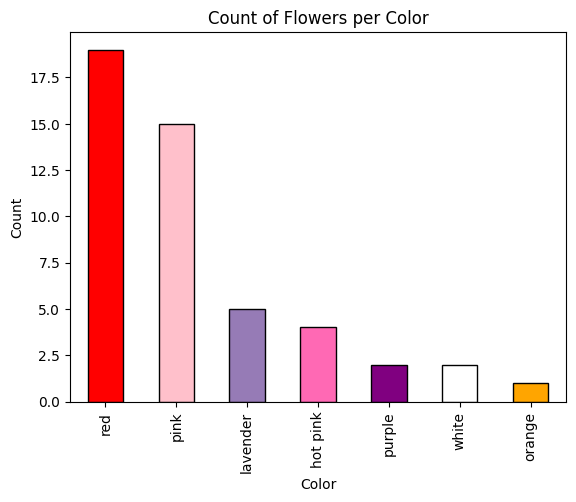

In [108]:
# Concatenate all dataframes in the dictionary into a single dataframe
# Create a new column 'Arrangement' which is the key in the dictionary
all_data = pd.concat([df.assign(Arrangement=os.path.splitext(name)[0]) for name, df in data.items()])
if not os.path.exists('Graphs'):
    os.makedirs('Graphs')

# Convert the color names to lowercase
all_data['Colors'] = all_data['Colors'].str.lower()
all_data['Colors'] = all_data['Colors'].str.strip()
all_data['Colors'] = all_data['Colors'].replace('light pink', 'pink')

# Define the custom colors
custom_colors = {
    'hot pink': '#FF69B4',
    'orange': '#FFA500',
    'pink': '#FFC0CB',
    'green': '#008000',
    'purple': '#800080',
    'yellow': '#FFFF00',
    'white': '#FFFFFF',
    'peach': '#ffcba4',
    'lavender': '#967bb6',
    'light pink': '#FFB6C1',
    'red': '#FF0000',
    'pale pink': '#FFEFD5',
    'blue': '#8EA5C5',
    'ivory': '#f5f5dc'
}

# Count the number of flowers per color
color_counts = all_data['Colors'].value_counts()
color_names = color_counts.index

# Plot the bar chart with custom colors and outline
color_counts.plot(kind='bar', color=[custom_colors.get(c, 'gray') for c in color_names], edgecolor='black')

plt.title('Count of Flowers per Color')
plt.xlabel('Color')
plt.ylabel('Count')
plt.savefig('graphs/Count of Flowers per Color')
plt.show()


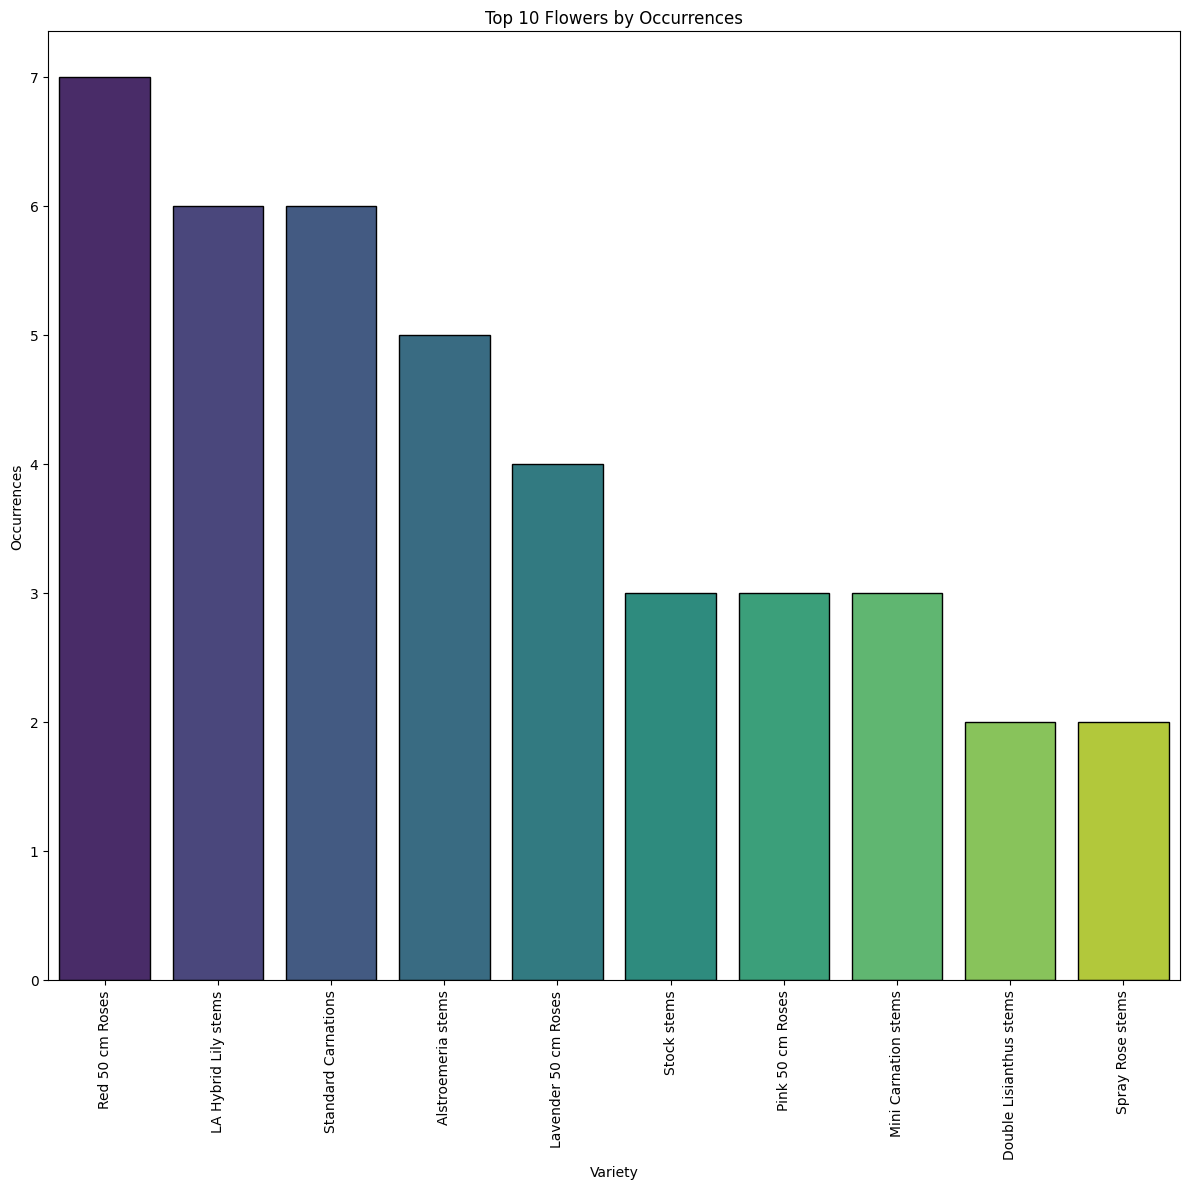

In [109]:
# Remove rows where 'Colors' is NaN
all_data = all_data[all_data['Colors'].notna()]

# Count the occurrences of each flower variety
variety_counts = all_data['Flowers'].value_counts()

# Select the top 10 varieties
top_varieties = variety_counts.head(10)

# Create a bar plot for the top 10 varieties
plt.figure(figsize=(12, 12))
sns.barplot(x=top_varieties.index, y=top_varieties.values, palette='viridis', edgecolor='black')

# Set title and labels
plt.title('Top 10 Flowers by Occurrences')
plt.xlabel('Variety')
plt.ylabel('Occurrences')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust subplot params
plt.savefig('graphs/Top 10 Flowers by Occurrences')

plt.show()


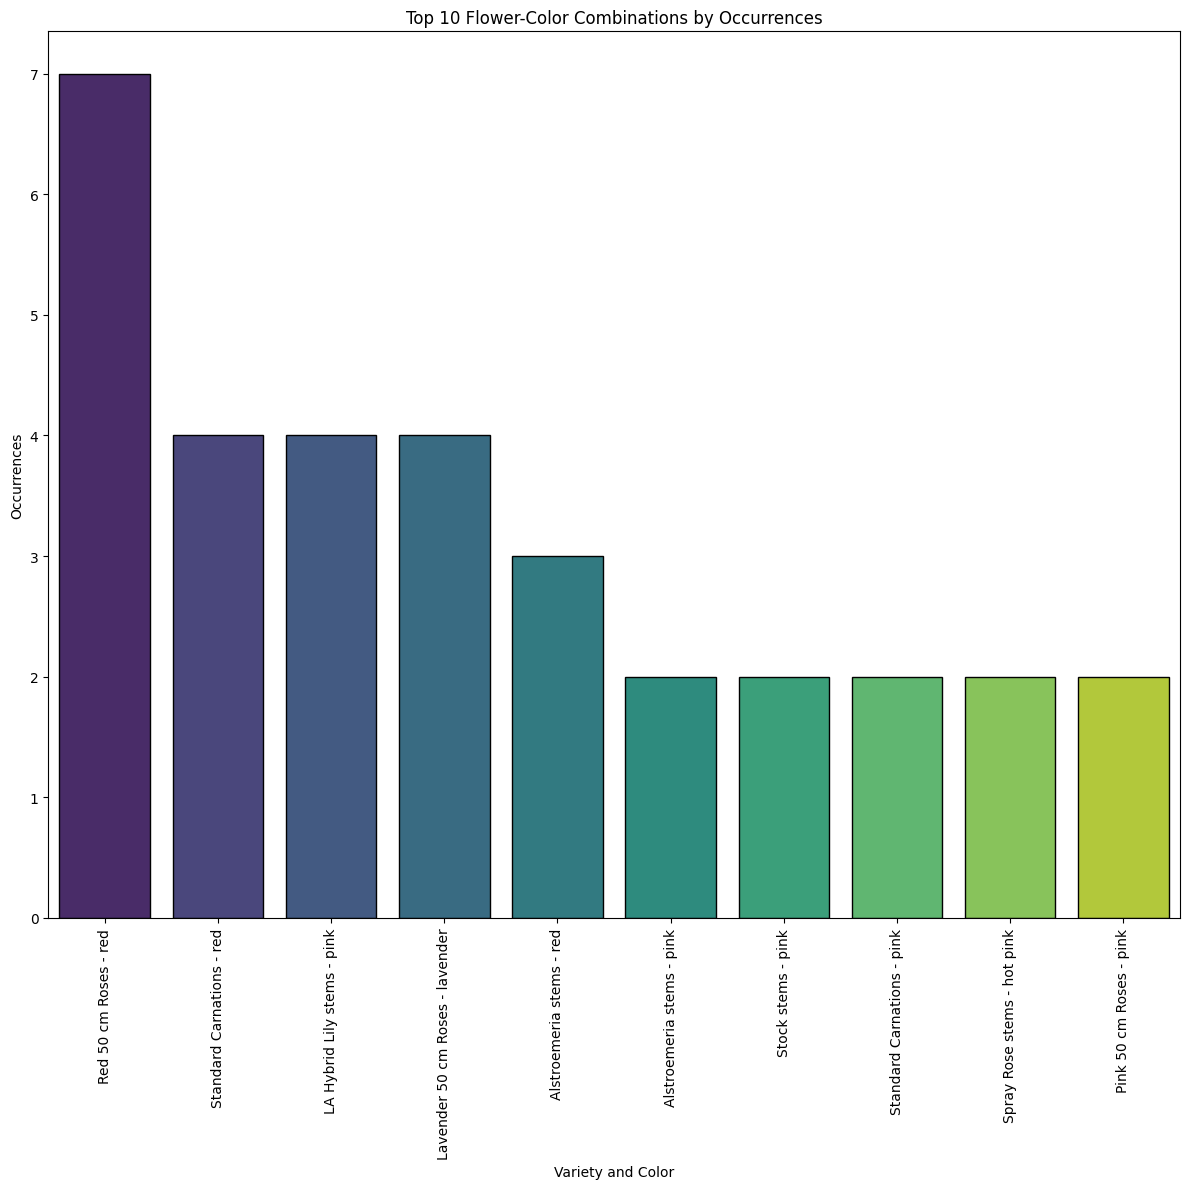

In [110]:
# Remove rows where 'Colors' is NaN
all_data = all_data[all_data['Colors'].notna()]

# Count the occurrences of each unique combination of 'Flowers' and 'Colors'
variety_color_counts = all_data.groupby(['Flowers', 'Colors']).size()

# Select the top 10 combinations
top_varieties_colors = variety_color_counts.sort_values(ascending=False).head(10)

# Convert the MultiIndex to a single index by joining the levels with a separator
top_varieties_colors.index = top_varieties_colors.index.map(' - '.join)

# Create a bar plot for the top 10 combinations
plt.figure(figsize=(12,12))
sns.barplot(x=top_varieties_colors.index, y=top_varieties_colors.values, palette='viridis', edgecolor='black')

# Set title and labels
plt.title('Top 10 Flower-Color Combinations by Occurrences')
plt.xlabel('Variety and Color')
plt.ylabel('Occurrences')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust subplot params
plt.savefig('graphs/Top 10 Flower-Color Combinations by Occurrences')

plt.show()


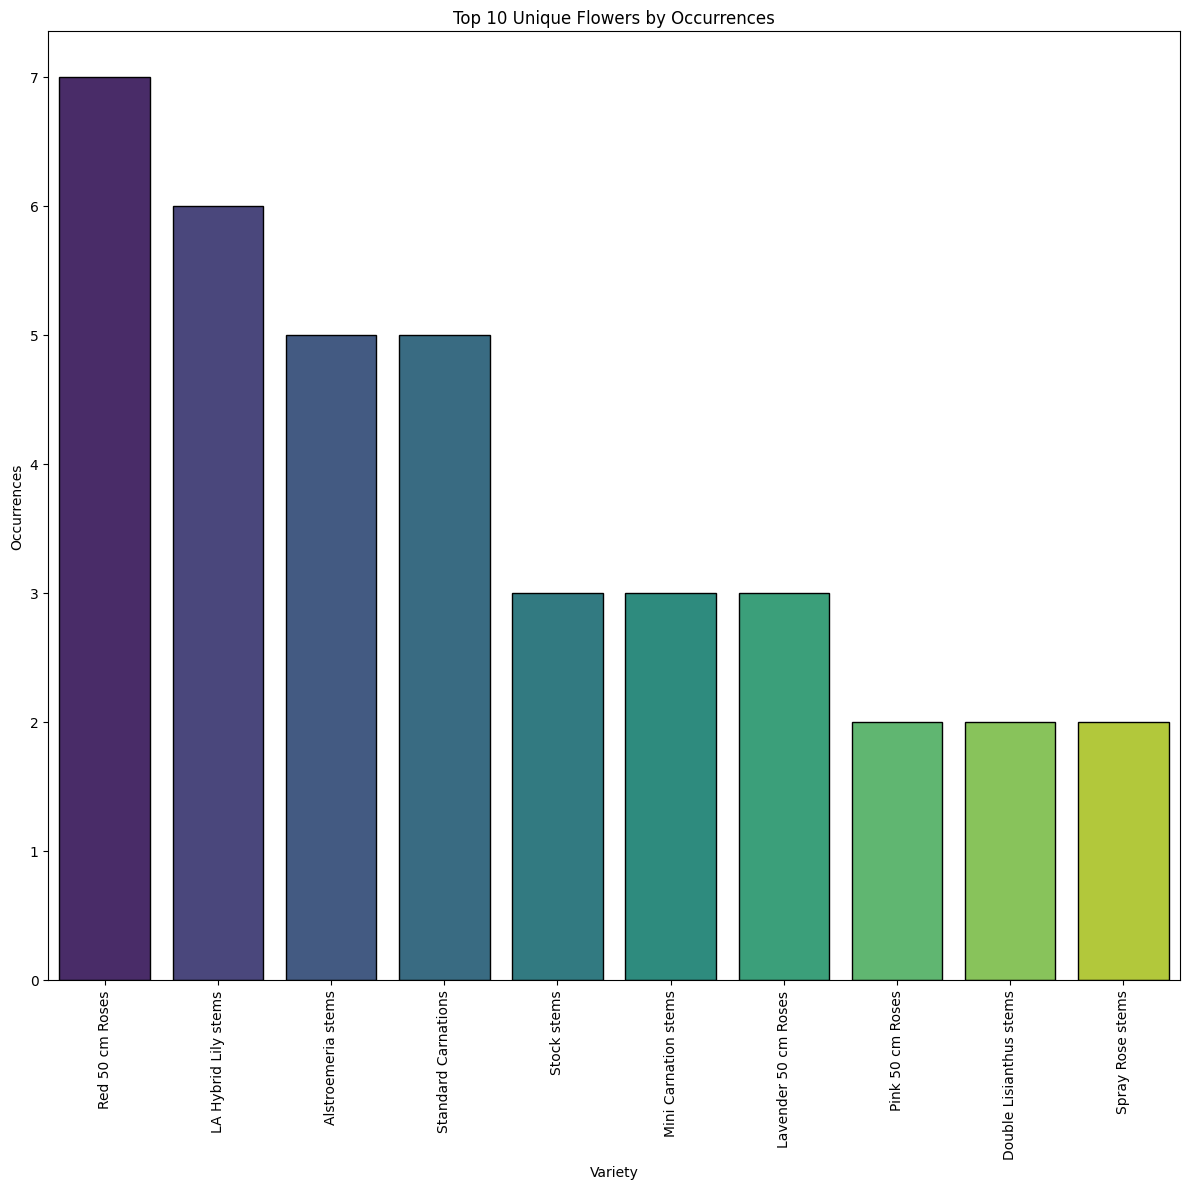

In [111]:
# Drop duplicates based on 'Arrangement' and 'Flowers'
all_data_unique_flowers = all_data.drop_duplicates(subset=['Arrangement', 'Flowers'])

# Count the occurrences of each 'Flowers' type
variety_counts = all_data_unique_flowers['Flowers'].value_counts()

# Select the top 10 varieties
top_varieties = variety_counts.head(10)

# Create a bar plot for the top 10 varieties
plt.figure(figsize=(12,12))
sns.barplot(x=top_varieties.index, y=top_varieties.values, palette='viridis', edgecolor='black')

# Set title and labels
plt.title('Top 10 Unique Flowers by Occurrences')
plt.xlabel('Variety')
plt.ylabel('Occurrences')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust subplot params
plt.savefig('graphs/Top 10 Unique Flowers by Occurrences')

plt.show()


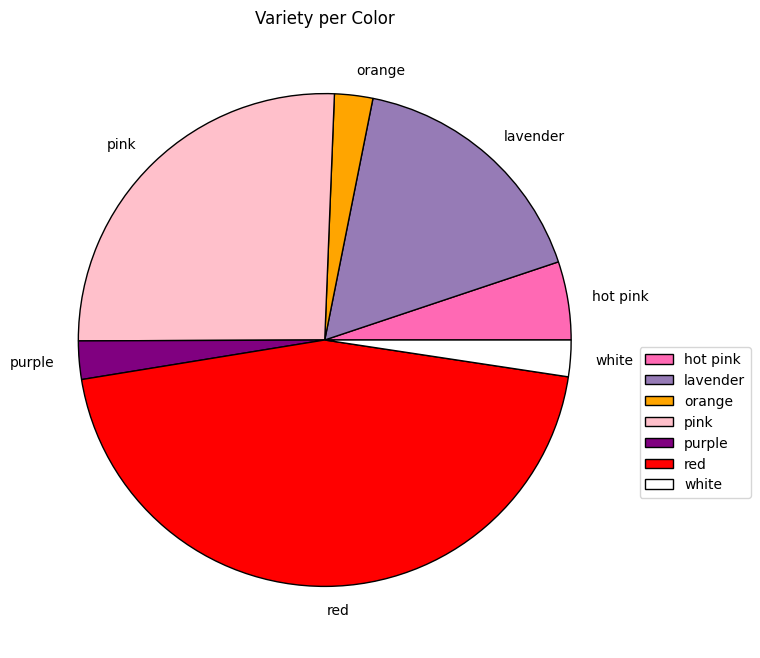

In [112]:
all_data['Colors'] = all_data['Colors'].str.lower()
all_data['Colors'] = all_data['Colors'].str.strip()
# Remove rows with NaN values in the 'Colors' column
all_data = all_data[all_data['Colors'].notna()]

# Convert the quantity columns to numeric
for col in ['SQty', 'DQty', 'PQty', 'EQty']:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce')

# Calculate the total volume for each color
color_volume = all_data.groupby('Colors')[['SQty', 'DQty', 'PQty', 'EQty']].sum().sum(axis=1)

# Filter out colors with 0 sales volume
color_volume = color_volume[color_volume != 0]

# Define the custom colors
custom_colors = {
    'hot pink': '#FF69B4',
    'orange': '#FFA500',
    'pink': '#FFC0CB',
    'green': '#008000',
    'purple': '#800080',
    'yellow': '#FFFF00',
    'white': '#FFFFFF',
    'peach': '#ffcba4',
    'lavender': '#967bb6',
    'light pink': '#FFB6C1',
    'red': '#FF0000',
    'pale pink': '#FFEFD5',
    'blue': '#8EA5C5',
    'ivory': '#f5f5dc'
}

# Create the pie chart with custom colors
custom_colors = {color: custom_colors.get(color, 'gray') for color in color_volume.index}
colors = [custom_colors[color] for color in color_volume.index]

# Adjust the figure size
plt.figure(figsize=(12,8))

# Create the pie chart with updated colors
patches, texts = plt.pie(color_volume.values, labels=color_volume.index, colors=colors, wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True})


plt.title('Variety per Color')

# Position the legend outside the chart area
plt.legend(patches, color_volume.index, bbox_to_anchor=(1, 0.5), loc='best')
plt.savefig('graphs/Pie Chart:Roses per Color Border')
plt.show()


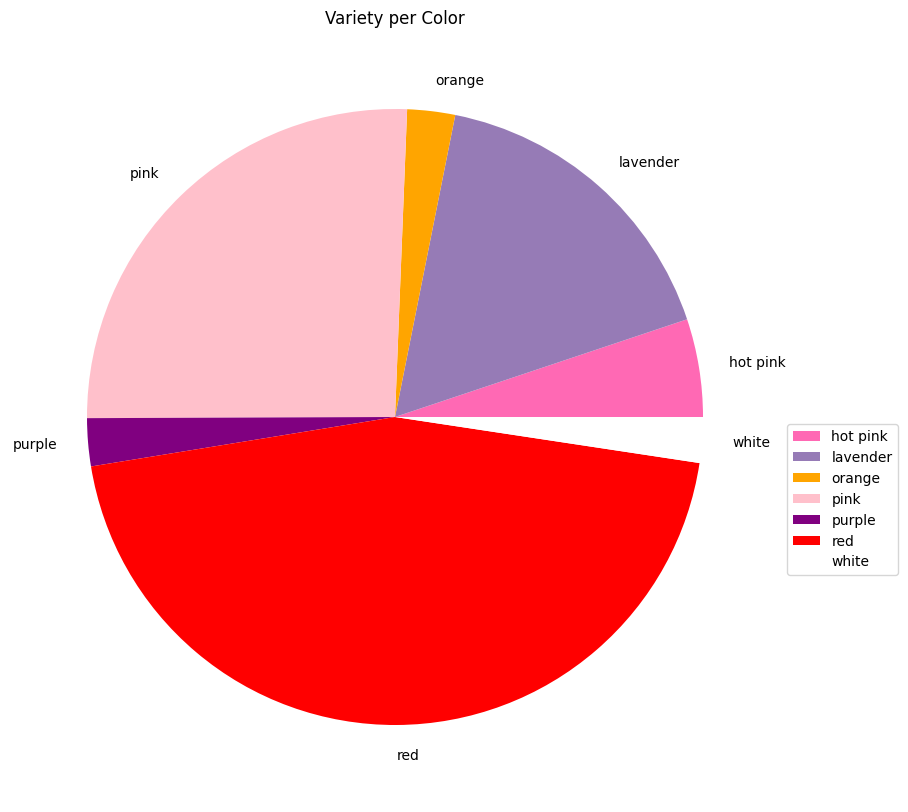

In [113]:
# Convert the quantity columns to numeric
for col in ['SQty', 'DQty', 'PQty', 'EQty']:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce')

# Calculate the total volume for each color
color_volume = all_data.groupby('Colors')[['SQty', 'DQty', 'PQty', 'EQty']].sum().sum(axis=1)

# Filter out colors with 0 sales volume
color_volume = color_volume[color_volume != 0]

# Define the custom colors
custom_colors = {
    'hot pink': '#FF69B4',
    'orange': '#FFA500',
    'pink': '#FFC0CB',
    'green': '#008000',
    'purple': '#800080',
    'yellow': '#FFFF00',
    'white': '#FFFFFF',
    'peach': '#ffcba4',
    'lavender': '#967bb6',
    'light pink': '#FFB6C1',
    'red': '#FF0000',
    'pale pink': '#FFEFD5',
    'blue': '#8EA5C5',
    'ivory': '#f5f5dc'
}

# Create the pie chart with custom colors
custom_colors = {color: custom_colors.get(color, 'gray') for color in color_volume.index}
colors = [custom_colors[color] for color in color_volume.index]

# Adjust the figure size
plt.figure(figsize=(12,10))

# Create the pie chart with updated colors
patches, texts = plt.pie(color_volume.values, labels=color_volume.index, colors=colors)


plt.title('Variety per Color')

# Position the legend outside the chart area
plt.legend(patches, color_volume.index, bbox_to_anchor=(1, 0.5), loc='best')
plt.savefig('graphs/Pie Chart:Variety per Color Borderless')
plt.show()


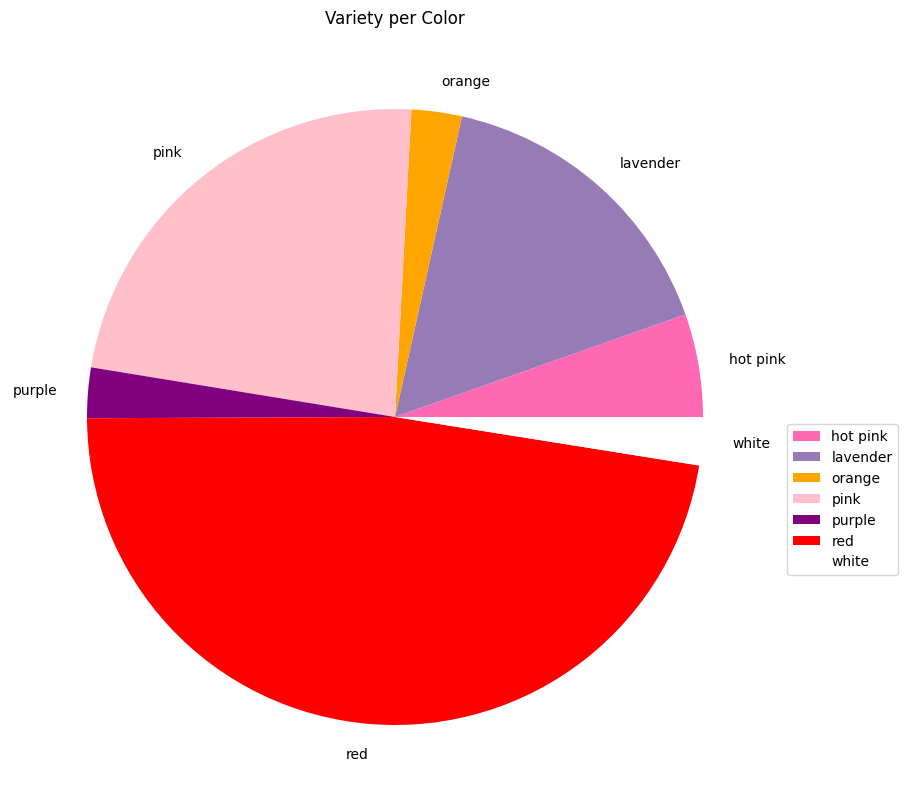

In [114]:
no_roses_arrangements = all_data.loc[~all_data['Arrangement'].isin(['2024_NEW-V15G'])].copy()

# Convert the quantity columns to numeric
for col in ['SQty', 'DQty', 'PQty', 'EQty']:
    no_roses_arrangements.loc[:, col] = pd.to_numeric(no_roses_arrangements.loc[:, col], errors='coerce')


# Calculate the total volume for each color
color_volume = no_roses_arrangements.groupby('Colors')[['SQty', 'DQty', 'PQty', 'EQty']].sum().sum(axis=1)

# Filter out colors with 0 sales volume
color_volume = color_volume[color_volume != 0]

# Define the custom colors
custom_colors = {
    'hot pink': '#FF69B4',
    'orange': '#FFA500',
    'pink': '#FFC0CB',
    'green': '#008000',
    'purple': '#800080',
    'yellow': '#FFFF00',
    'white': '#FFFFFF',
    'peach': '#ffcba4',
    'lavender': '#967bb6',
    'light pink': '#FFB6C1',
    'red': '#FF0000',
    'pale pink': '#FFEFD5',
    'blue': '#8EA5C5',
    'ivory': '#f5f5dc'
}

# Create the pie chart with custom colors
custom_colors = {color: custom_colors.get(color, 'gray') for color in color_volume.index}
colors = [custom_colors[color] for color in color_volume.index]

# Adjust the figure size
plt.figure(figsize=(12,10))

# Create the pie chart with updated colors
patches, texts = plt.pie(color_volume.values, labels=color_volume.index, colors=colors)

plt.title('Variety per Color')

# Position the legend outside the chart area
plt.savefig('graphs/Pie Chart:Variety per Color with out V15G Borderless')
plt.legend(patches, color_volume.index, bbox_to_anchor=(1, 0.5), loc='best')
plt.show()



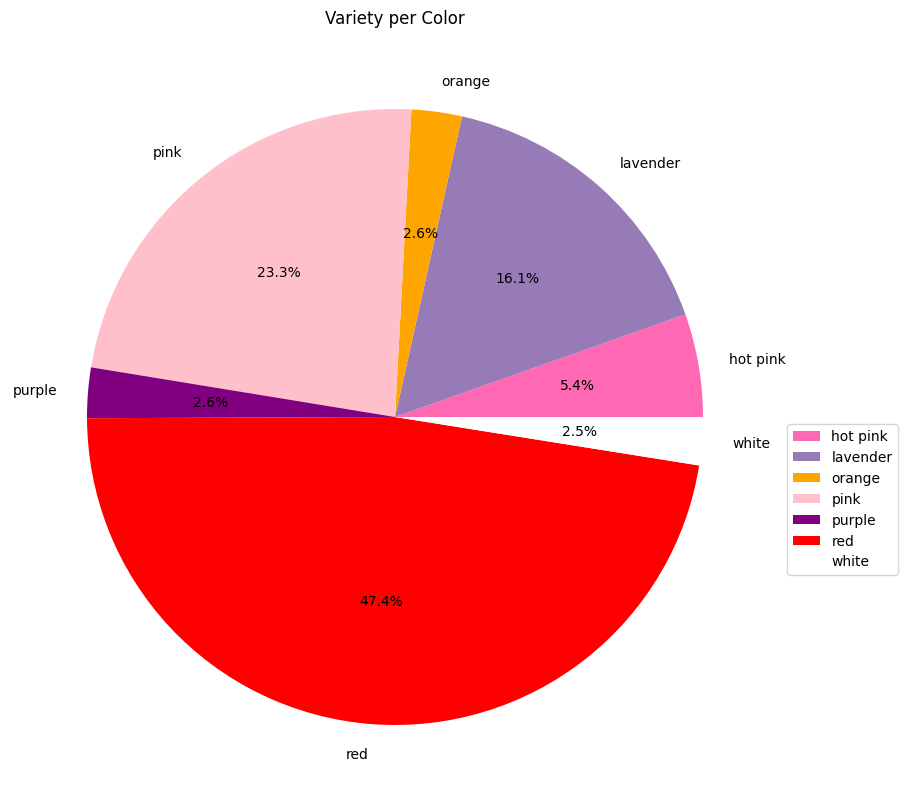

In [115]:
# Convert the quantity columns to numeric
for col in ['SQty', 'DQty', 'PQty', 'EQty']:
    no_roses_arrangements.loc[:, col] = pd.to_numeric(no_roses_arrangements.loc[:, col], errors='coerce')

# Calculate the total volume for each color
color_volume = no_roses_arrangements.groupby('Colors')[['SQty', 'DQty', 'PQty', 'EQty']].sum().sum(axis=1)

# Filter out colors with 0 sales volume
color_volume = color_volume[color_volume != 0]

# Define the custom colors
custom_colors = {
    'hot pink': '#FF69B4',
    'orange': '#FFA500',
    'pink': '#FFC0CB',
    'green': '#008000',
    'purple': '#800080',
    'yellow': '#FFFF00',
    'white': '#FFFFFF',
    'peach': '#ffcba4',
    'lavender': '#967bb6',
    'light pink': '#FFB6C1',
    'red': '#FF0000',
    'pale pink': '#FFEFD5',
    'blue': '#8EA5C5',
    'ivory': '#f5f5dc'
}

# Create the pie chart with custom colors
custom_colors = {color: custom_colors.get(color, 'gray') for color in color_volume.index}
colors = [custom_colors[color] for color in color_volume.index]

# Adjust the figure size
plt.figure(figsize=(12,10))

# Create the pie chart with updated colors and percentages
patches, texts, autotexts = plt.pie(color_volume.values, labels=color_volume.index, colors=colors, autopct='%1.1f%%')

# Improve legibility of percent labels
for autotext in autotexts:
    autotext.set_color('black')

plt.title('Variety per Color')

# Position the legend outside the chart area
plt.savefig('graphs/Pie Chart:Variety per Color with out V15G Borderless + Percents')
plt.legend(patches, color_volume.index, bbox_to_anchor=(1, 0.5), loc='best')
plt.show()


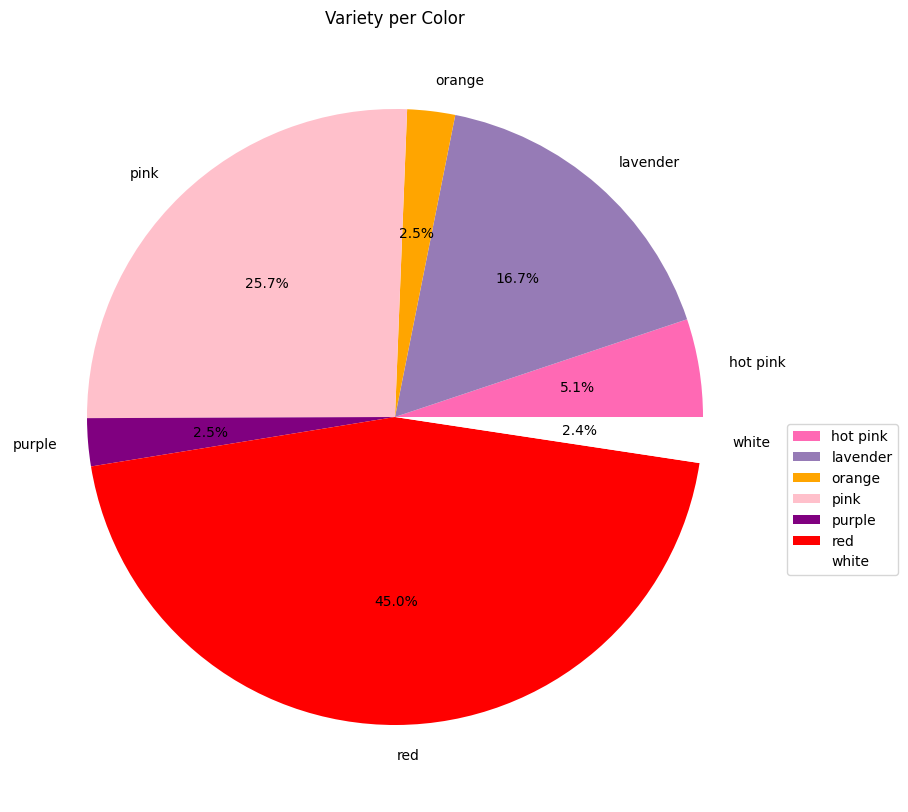

In [116]:
# Convert the quantity columns to numeric
for col in ['SQty', 'DQty', 'PQty', 'EQty']:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce')

# Calculate the total volume for each color
color_volume = all_data.groupby('Colors')[['SQty', 'DQty', 'PQty', 'EQty']].sum().sum(axis=1)

# Filter out colors with 0 sales volume
color_volume = color_volume[color_volume != 0]

# Define the custom colors
custom_colors = {
    'hot pink': '#FF69B4',
    'orange': '#FFA500',
    'pink': '#FFC0CB',
    'green': '#008000',
    'purple': '#800080',
    'yellow': '#FFFF00',
    'white': '#FFFFFF',
    'peach': '#ffcba4',
    'lavender': '#967bb6',
    'light pink': '#FFB6C1',
    'red': '#FF0000',
    'pale pink': '#FFEFD5',
    'blue': '#8EA5C5',
    'ivory': '#f5f5dc'
}

# Create the pie chart with custom colors
custom_colors = {color: custom_colors.get(color, 'gray') for color in color_volume.index}
colors = [custom_colors[color] for color in color_volume.index]

# Adjust the figure size
plt.figure(figsize=(12,10))

# Create the pie chart with updated colors and percentages
patches, texts, autotexts = plt.pie(color_volume.values, labels=color_volume.index, colors=colors, autopct='%1.1f%%')

# Improve legibility of percent labels
for autotext in autotexts:
    autotext.set_color('black')

plt.title('Variety per Color')

# Position the legend outside the chart area
plt.legend(patches, color_volume.index, bbox_to_anchor=(1, 0.5), loc='best')
plt.savefig('graphs/Pie Chart:Variety per Color Borderless + Percents')
plt.show()



In [117]:
# Remove the filter to include all arrangements
all_arrangements = all_data

# Drop duplicates to ensure each flower type is counted only once per arrangement
all_unique_flowers = all_arrangements.drop_duplicates(subset=['Arrangement', 'Flowers'])

# Count the occurrences of each color and flower type
color_counts = all_arrangements['Colors'].value_counts()
flower_counts = all_unique_flowers['Flowers'].value_counts()

print("Most common colors among all arrangements:")
print(color_counts)
print("\nMost common flower types among all arrangements:")
print(flower_counts)


Most common colors among all arrangements:
Colors
red         19
pink        15
lavender     5
hot pink     4
purple       2
white        2
orange       1
Name: count, dtype: int64

Most common flower types among all arrangements:
Flowers
Red 50 cm Roses            7
LA Hybrid Lily stems       6
Alstroemeria stems         5
Standard Carnations        5
Stock stems                3
Mini Carnation stems       3
Lavender 50 cm Roses       3
Pink 50 cm Roses           2
Double Lisianthus stems    2
Spray Rose stems           2
Red 60 cm Roses            1
Hypericum Berry stems      1
Orange 50 cm Roses         1
Salal tips                 1
Cushion Pompon stems       1
Daisy Pompon stems         1
Gerbera Daisies            1
Name: count, dtype: int64


In [123]:
# Calculate the total quantity for each flower variety
all_data['Total Qty'] = all_data[['SQty', 'DQty', 'PQty', 'EQty']].sum(axis=1)

# Fill missing 'Colors' values with an empty string
all_data['Colors'] = all_data['Colors'].fillna('')

# Remove the '2024_' prefix from the SKUs
all_data['Arrangement'] = all_data['Arrangement'].str.replace('2024_', '')

# Create the first sheet: count of each variety in each SKU
df_sku_flower_count = all_data.pivot_table(index=['Colors', 'Flowers'], columns='Arrangement', values='Total Qty', aggfunc='sum', fill_value=0)

# Create the second sheet: presence of each variety in each SKU
df_sku_flower_presence = all_data.pivot_table(index=['Colors', 'Flowers'], columns='Arrangement', values='Total Qty', aggfunc=lambda x: 1 if len(x) > 0 else 0, fill_value=0)

# Output the two sheets to an Excel file
with pd.ExcelWriter('Excel_Outputs/VDay23 flower grid.xlsx') as writer:  
    df_sku_flower_count.to_excel(writer, sheet_name='SKU_Flower_Count')
    df_sku_flower_presence.to_excel(writer, sheet_name='SKU_Flower_Presence')
